In [1]:
#EP Phys 512
#Question 5

In [2]:
import numpy as np
import matplotlib.pyplot as mpl
from wmap_camb_example import get_spectrum
import corner

In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplo

#### ORDER OF NOTEBOOK

##### IMPORTANCE SAMPLING: 
Here I perform importance sampling on the Markov chain from 4) version 1 (...that used a cholesky matrix generated from the curvature matrix of the 5 parameters with the curvature matrix (single number) for tau inserted after).

##### Methods of priors:
I used two different methods for imposing the prior on tau:

1. I changed the probability of acceptance to be multiplied by the gaussian probability distribution of tau with mean = 0.0544 and std = 0.0073 as specified in the problem
2. I used an edge to simply reject any steps that took tau out of 1 sigma.

Both of these seemed to work; rejecting any steps taking tau out of 1 sigma gave tighter errors on tau, but slightly worse errors on the rest of the parameters. These trials were done back with the cholesky matrix from the curvature matrix for all 6 parameters done simultaneously, so the convergence wasn't great.

Sampling with steps sizes rather than cholesky was also tried but abandoned.

Presented in this code is the chain run with cholesky (with curvature done seperately for tau) using method 1, changing the probability of acceptance.



###### Burn in
Note that I have not discarded the beginning of my chains, because there is no discernible burn-in as we started basically on the most likely best-fit parameters already.

In [3]:
#providing chi2 for the data
def chi2(data, pars):
    ypred = get_spectrum(pars)
    ypred = ypred[2:1199+2] #chop down to correct size
    return np.sum( (data[:,1] - ypred)**2/data[:,2]**2 ) #wmap[:,1] =data , 2=std on data point

def acceptance_rate(chain):
    count = sum( (chain[1:, 0] - chain[0:-1, 0] ) != 0)
    acc_rate = count/chain.shape[0]
    print('total count is ', count)
    print('length of chain is ', chain.shape[0])
    print('acceptance rate is ', acc_rate)
    return acc_rate

#this prior method tries to scale the probability of acceptance to staying around tau's given mean and std
#it does this by incorporating the gaussian probability of tau in the acceptance criteria
def markov_cholesky_prior(pars, wmap, r, chi2fun, n):
    count_neg_tau = 0

    #create data holding members
    npar = len(pars)
    chain = np.zeros([n, npar]) #track each step for each parameter in chain
    chi2vec = np.zeros(n) #keep track of chi2 at each step

    #calculate chi2 to determine step condition
    chi2_cur = chi2fun(wmap,pars)
    print('our current chi2 value is ', chi2_cur)
    
    #need information about prior on tau
    tau_mean = 0.0544
    tau_std = 0.0073
    tau_idx = 3 #third element in parameter array

    #do actual chain calculations
    for ii in range(n):
        pars_trial = pars + np.dot(r, np.random.randn(r.shape[0])) #add dist drawn from cholesky
        if pars_trial[tau_idx] > 0: #only go forward if tau is positive, can't be negative
            chi2_trial = chi2fun(wmap, pars_trial) #check what chi2 value that would give
            tau_gauss = np.exp(-0.5*( (pars_trial[tau_idx]-tau_mean)**2/tau_std**2)) #restricts step to desired tau
            accept_prob = tau_gauss*np.exp(-0.5*(chi2_trial - chi2_cur)) #prob that we take step
            if np.random.rand(1) < accept_prob: #take step
                pars=pars_trial
                chi2_cur = chi2_trial
        else: #tau was negative.
            count_neg_tau += 1
        chain[ii, :] = pars #keep track of where we've been
        chi2vec[ii]=chi2_cur
    #     print('iter ', ii, ' pars ', pars)
    #     print('chi2_cur ', chi2_cur)
    print('finished chain. ', count_neg_tau, ' steps rejected to maintain tau>0')
    return chain, chi2vec


#this markov chain tries to incorporate the prior on tau by restricting tau steps to within 1 sigma
def markov_cholesky_edge(pars, wmap, r, chi2fun, n):
    count_neg_tau = 0

    #create data holding members
    npar = len(pars)
    chain = np.zeros([n, npar]) #track each step for each parameter in chain
    chi2vec = np.zeros(n) #keep track of chi2 at each step

    #calculate chi2 to determine step condition
    chi2_cur = chi2fun(wmap,pars)
    print('our current chi2 value is ', chi2_cur)
    
    #need information about prior on tau
    tau_mean = 0.0544
    tau_std = 0.0073
    tau_idx = 3 #third element in parameter array

    #do actual chain calculations
    for ii in range(n):
        pars_trial = pars + np.dot(r, np.random.randn(r.shape[0])) #add dist drawn from cholesky
        if (pars_trial[tau_idx] > (tau_mean - tau_std)) and (pars_trial[tau_idx] < (tau_mean + tau_std)): #only go forward if tau is positive, can't be negative
            chi2_trial = chi2fun(wmap, pars_trial) #check what chi2 value that would give
            accept_prob = np.exp(-0.5*(chi2_trial - chi2_cur)) #prob that we take step
            if np.random.rand(1) < accept_prob: #take step
                pars=pars_trial
                chi2_cur = chi2_trial
        else: #tau was negative.
            count_neg_tau += 1
        chain[ii, :] = pars #keep track of where we've been
        chi2vec[ii]=chi2_cur
    #     print('iter ', ii, ' pars ', pars)
    #     print('chi2_cur ', chi2_cur)
    print('finished chain. ', count_neg_tau, ' steps rejected to maintain tau within 1 sigma')
    return chain, chi2vec

def markov_stepsize_prior(pars, wmap, par_step, chi2fun, n):
#     count_neg_tau = 0

    #create data holding members
    npar = len(pars)
    chain = np.zeros([n, npar]) #track each step for each parameter in chain
    chi2vec = np.zeros(n) #keep track of chi2 at each step

    #calculate chi2 to determine step condition
    chi2_cur = chi2fun(wmap,pars)
    print('our current chi2 value is ', chi2_cur)
    
    #need information about prior on tau
    tau_mean = 0.0544
    tau_std = 0.0073
    tau_idx = 3 #third element in parameter array

    #do actual chain calculations
    for ii in range(n):
        pars_trial = pars+np.random.randn(npar)*par_step #randomly add to each parameters
        if pars_trial[3] > 0: #only go forward if tau is positive, can't be negative
            chi2_trial = chi2fun(wmap, pars_trial) #check what chi2 value that would give
            tau_gauss = np.exp(-0.5*( (pars_trial[tau_idx]-tau_mean)**2/tau_std**2)) #restricts step to desired tau
            accept_prob = tau_gauss*np.exp(-0.5*(chi2_trial - chi2_cur)) #prob that we take step
            if np.random.rand(1) < accept_prob: #take step
                pars=pars_trial
                chi2_cur = chi2_trial
#         else: #tau was negative.
#             count_neg_tau += 1
        chain[ii, :] = pars #keep track of where we've been
        chi2vec[ii]=chi2_cur
    #     print('iter ', ii, ' pars ', pars)
    #     print('chi2_cur ', chi2_cur)
#     print('finished chain. ', count_neg_tau, ' steps rejected to maintain tau>0')
    return chain, chi2vec

### Importance sampling

(20000, 6)
(20000,)
mean would be  [6.98699656e+01 2.26108853e-02 1.13187952e-01 6.36210917e-02
 2.10101288e-09 9.73973272e-01]
errors would be  [2.59600026e+00 5.79098261e-04 5.42025749e-03 3.61256320e-02
 1.48507793e-10 1.54588163e-02]

 weighted mean is  [6.72054986e+01 2.27709848e-02 1.24281104e-01 5.05802814e-02
 2.12988636e-09 9.58807168e-01]
weighted errors are  [4.31424255e+00 5.95261370e-04 1.02925188e-02 3.28183522e-03
 5.96053190e-11 1.65270342e-02]

 FINAL WEIGHTED VALUES: 
final value for par  h0  :  67.20549859877003  error:  4.3142425535851485
final value for par  wbh^2  :  0.022770984832348285  error:  0.0005952613702927747
final value for par  wch^2  :  0.1242811035965046  error:  0.01029251883779077
final value for par  tau  :  0.05058028139166173  error:  0.003281835218600055
final value for par  As  :  2.129886362959842e-09  error:  5.960531895850692e-11
final value for par  pwrlaw  :  0.9588071678449408  error:  0.01652703423401881


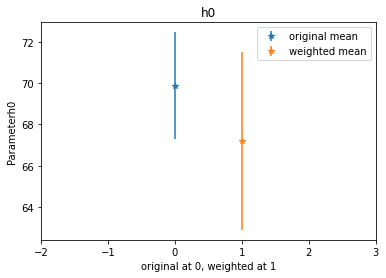

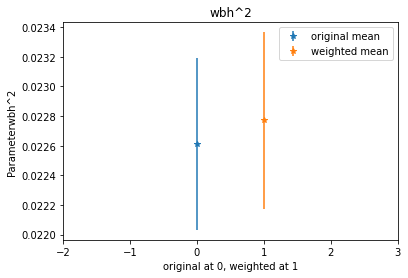

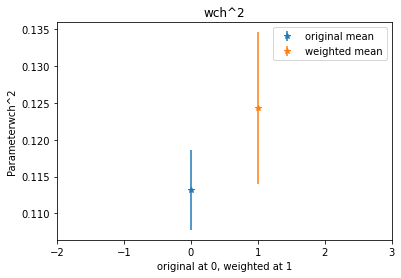

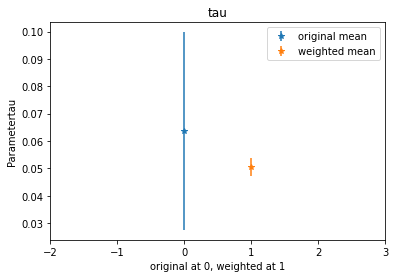

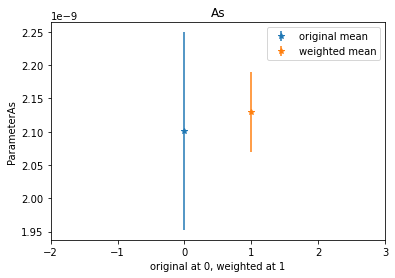

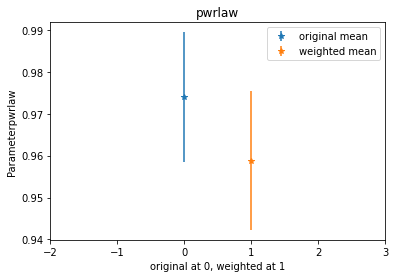

In [4]:
#IMPORTANCE SAMPLING
#given PRIOR on data samples, want to do importance weighting
#given information on tau. mean = 0.0544, std is 0.0073

chain = np.loadtxt("chain20k_tauseperate.txt")
chi2vec = np.loadtxt("chi2vec20k_tauseperate.txt")
print(chain.shape)
print(chi2vec.shape)

#obtain the mean and errors on the parameters without importance waiting
par_mean = np.mean(chain, axis=0)
par_errs = np.std(chain, axis=0)
print('mean would be ', par_mean)
print('errors would be ', par_errs)

#prior information on tau
tau_idx=3
tau_mean=0.0544
tau_std=0.0073

dchi2 = np.zeros(len(chi2vec))
dchi2 = chi2vec - np.median(chi2vec) #approximate delta chi squared

weights = np.exp(-0.5*( (chain[:,tau_idx]-tau_mean)**2/tau_std**2) + dchi2)

par_mean_weighted = np.zeros(chain.shape[1])
par_errs_weighted = np.zeros(chain.shape[1])
chain_scat = np.zeros(chain.shape)

#go through and get weighted mean for each parameter
for ii in range(chain.shape[1]):
    par_mean_weighted[ii] = np.sum(weights*chain[:, ii])/np.sum(weights)
    chain_scat[:, ii] = chain[:, ii] - par_mean_weighted[ii] #see how much chain moves around mean for each par
    par_errs_weighted[ii] = np.sqrt( np.sum( (chain_scat[:,ii]**2)*weights ) /np.sum(weights) ) #gives standard deviation
    
print('\n weighted mean is ', par_mean_weighted)
print('weighted errors are ', par_errs_weighted)

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
print('\n FINAL WEIGHTED VALUES: ')
for ii in range(chain.shape[1]):
    print('final value for par ', par_lab[ii], ' : ', par_mean_weighted[ii], ' error: ', par_errs_weighted[ii])


for ii in range(chain.shape[1]):
    mpl.figure()
    mpl.title(par_lab[ii])
    mpl.errorbar(0, par_mean[ii], yerr=par_errs[ii], fmt='*')
    mpl.errorbar(1, par_mean_weighted[ii], yerr=par_errs_weighted[ii], fmt='*')
    mpl.xlabel('original at 0, weighted at 1')
    mpl.legend(['original mean', 'weighted mean'])
    mpl.ylabel('Parameter' + par_lab[ii])
    mpl.xlim([-2,3])
    mpl.show()

Performing the importance sampling using the information on tau greatly helps with the estimating the mean of tau, and greatly reduces the error on tau. However, the errors on most of the other parameters are increased slightly, but the tradeoff is actually having a reasonable tau, which is worth it.

In [5]:
# TIME TO RUN SOME MARKOV CHAINS
#set up some parameters

wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt') #this is the data

#use best fit parameters from previous section 3
pars = np.asarray([6.93351658e+01, 2.24911838e-02, 1.13886400e-01, 5.00000000e-02,
 2.04230773e-09, 9.69783026e-01])


#### MARKOV CHAIN FITTING STEPS

FIRST: compared two methods of sampling with the given information on tau.
changing the probability of acceptance by including the prior gaussian dist of tau into acceptance
making an edge where tau is not allowed to go out
sampled for 12000 points. 
used cholesky method.
not very converged at all, about 1% acceptance rate. as expected, the edge version had smaller errors on tau because it restricts it more, and slightly lower acceptance rate (0.12 rather than 0.14 for the other version).

SECOND: reran markov chain with the prior version with STEP SIZE rather than cholesky, step size and parameters drawn from new errors.



In [6]:
#SAMPLING WITH A PRIOR
#before we've already seen sampling with an edge saying that tau>0
#here we want to restrict tau from leaving the vicinity of the mean 0.0544 with std 0.0073

if False: #if we want to fit using the cholesky matrix from part 3
    
    #generate cholesky matrix
#     mat = np.loadtxt('newton_lhs.txt')
    mat = np.loadtxt('lhs_tot.txt')
    r = np.linalg.cholesky(np.linalg.inv(mat)) #create cholesky matrix for generating pars

    n=20000
    #using the prior this way will drop acceptance, we'll see by how much, less steps accepted
    chain_prior, chi2vec_prior = markov_cholesky_prior(pars, wmap, r, chi2, n)
    print('finished cholesky chain with acceptance rate ', acceptance_rate(chain_prior))
    
    np.savetxt('chainprior.txt', chain_prior)
    np.savetxt('chi2vecprior.txt', chi2vec_prior)
    
    #copy matrices. paranoid of accidental erasures even after they're written to txt
    chain = chain_prior.copy()
    chi2vec = chi2vec_prior.copy()

In [7]:
#SAMPLING WITH A STRICTER EDGE
#before we've already seen sampling with an edge saying that tau>0
#here we want to restrict tau from leaving the vicinity of the mean 0.0544 with std 0.0073

if False: #if we want to fit using the cholesky matrix from part 3
    
    #generate cholesky matrix
    mat = np.loadtxt('newton_lhs.txt')
    r = np.linalg.cholesky(np.linalg.inv(mat)) #create cholesky matrix for generating pars

    n=12000
    #using the prior this way will drop acceptance, we'll see by how much, less steps accepted
    chain_edge, chi2vec_edge = markov_cholesky_edge(pars, wmap, r, chi2, n)
    print('finished cholesky chain with acceptance rate ', acceptance_rate(chain_edge))
    
#     np.savetxt('chainedge.txt', chain_edge)
#     np.savetxt('chi2vecedge.txt', chi2vec_edge)
    
    #copy matrices. paranoid of accidental erasures even after they're written to txt
    chain = chain_edge.copy()
    chi2vec = chi2vec_edge.copy()

In [8]:
#SAMPLING WITH PRIORS AND NEW STEP SIZES AND PARAMETERS

if False:
    chain_prev = np.loadtxt('chainprior12k.txt')
    pars = np.mean(chain_prev, axis=0)
    par_step = np.std(chain_prev, axis=0)

    print('parameters and step size going in are \n', pars, ' \n', par_step)

    n = 10000
    
    chain_prior_step, chi2vec_prior_step = markov_stepsize_prior(pars, wmap, par_step, chi2, n)
    
    print('finished cholesky chain with acceptance rate ', acceptance_rate(chain_prior_step))

    np.savetxt('chainpriorstep.txt', chain_prior_step)
    np.savetxt('chi2vecpriorstep.txt', chi2vec_prior_step)
    
    #copy matrices. paranoid of accidental erasures even after they're written to txt
    chain = chain_prior_step.copy()
    chi2vec = chi2vec_prior_step.copy()
    

### MCMC Chain results with prior and good cholesky matrix

In [9]:
#load data rather than regenerate

chain = np.loadtxt('chainprior20k_lhstot.txt')
chi2vec = np.loadtxt('chi2vecprior20k_lhstot.txt')

# chain = np.loadtxt('chainedge.txt')
# chi2vec = np.loadtxt('chi2vecedge.txt')

chain sigmas are  [2.11230190e+00 4.76669731e-04 4.44966832e-03 8.30759582e-03
 4.57998155e-11 1.16798365e-02]
chain means are  [6.95495586e+01 2.25113360e-02 1.13477723e-01 5.68225846e-02
 2.06759001e-09 9.70256327e-01]

 FINAL VALUES: 
final value for par  h0  :  69.5495585902042  error:  2.112301901194533
final value for par  wbh^2  :  0.022511336039129387  error:  0.00047666973082954005
final value for par  wch^2  :  0.11347772313574708  error:  0.004449668315003294
final value for par  tau  :  0.056822584570994525  error:  0.008307595815891243
final value for par  As  :  2.067590014669893e-09  error:  4.5799815462641156e-11
final value for par  pwrlaw  :  0.9702563274885175  error:  0.011679836516182132


total count is  3518
length of chain is  20000
acceptance rate is  0.1759
the acceptance rate of the chain is  0.1759


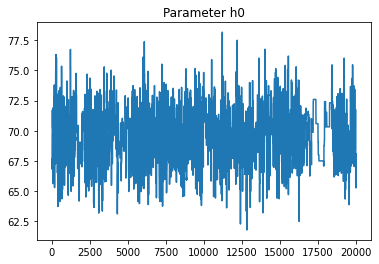

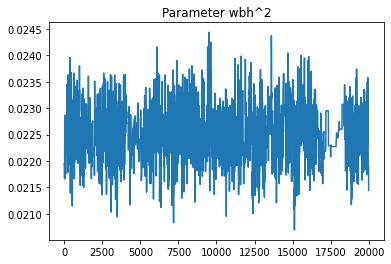

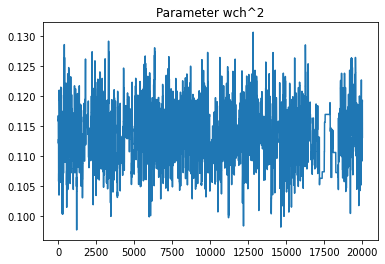

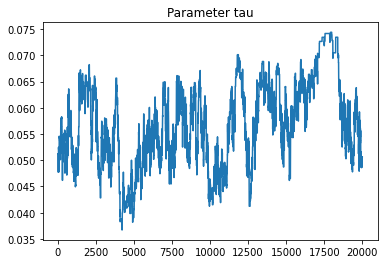

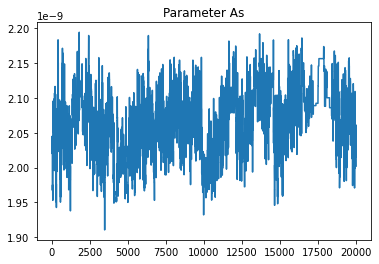

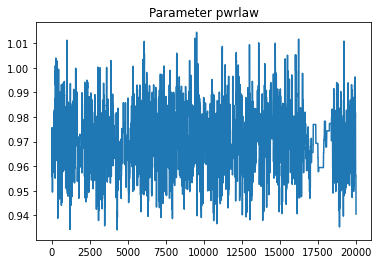

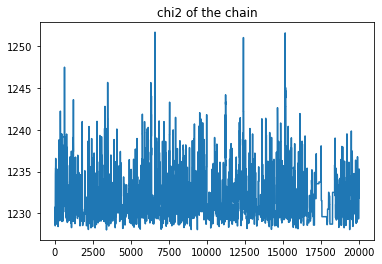

In [10]:
chainmeans = np.mean(chain, axis=0)
chainsigs = np.std(chain, axis=0)
print('chain sigmas are ', chainsigs)
print('chain means are ', chainmeans)

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
print('\n FINAL VALUES: ')
for ii in range(chain.shape[1]):
    print('final value for par ', par_lab[ii], ' : ', chainmeans[ii], ' error: ', chainsigs[ii])

print('\n')
print('the acceptance rate of the chain is ', acceptance_rate(chain))

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
for ii in range(len(pars)):
    mpl.figure()
    mpl.plot(chain[:, ii])
    mpl.title('Parameter ' + par_lab[ii])
    mpl.show()
    
mpl.figure()
mpl.plot(chi2vec)
mpl.title('chi2 of the chain')
mpl.show()

Convergence is mostly good, except for one spot where tau goes super high and all the parameters freak out. Tau and As, just as in 4), have a worse convergence than the rest of the parameters - but it seems better than the convergence in 4).

corner plot of chain 


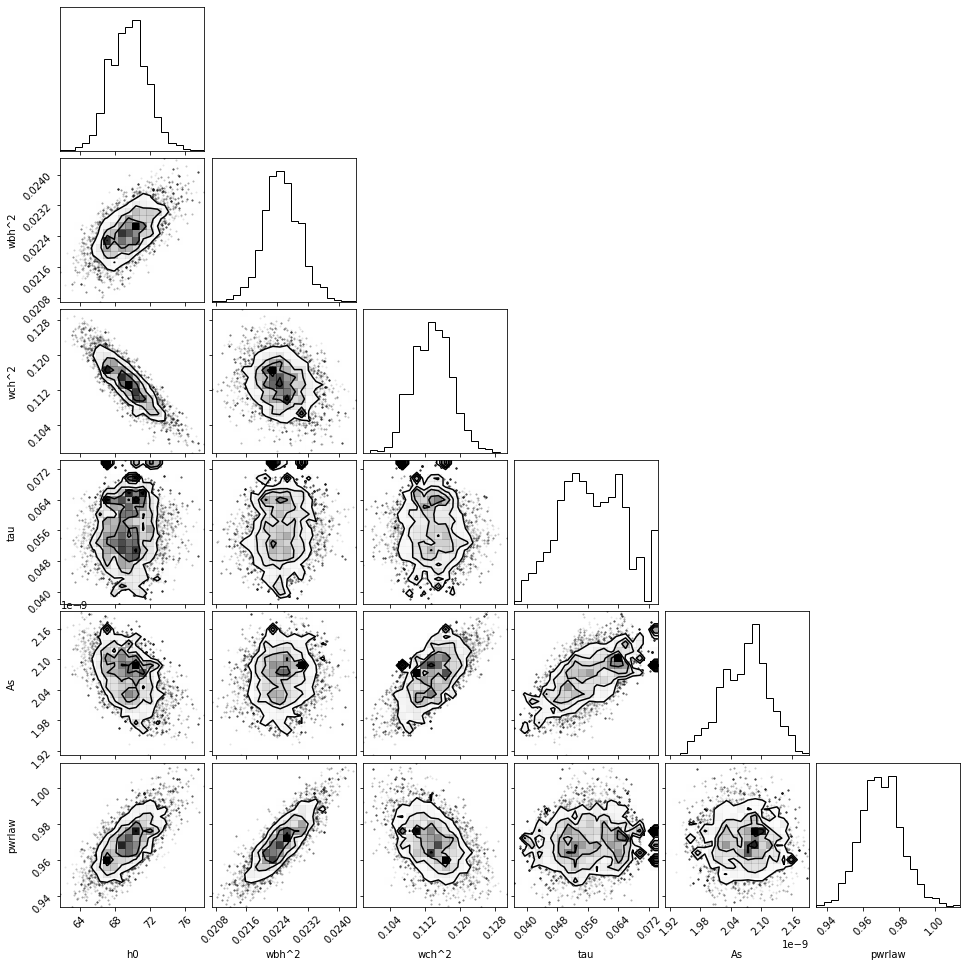

In [11]:
print('corner plot of chain ')
figure = corner.corner(chain, labels=['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw'])

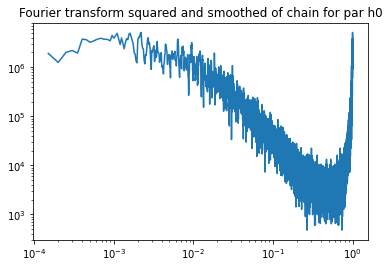

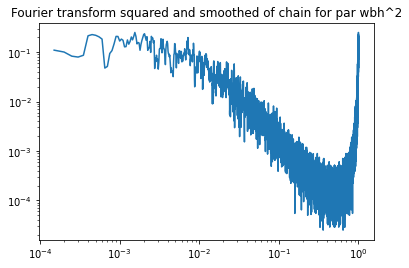

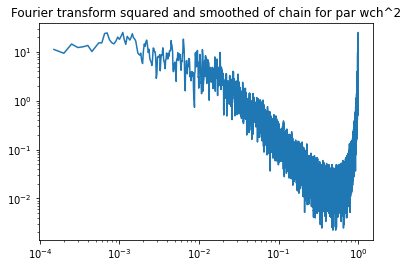

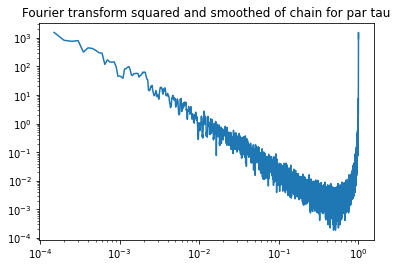

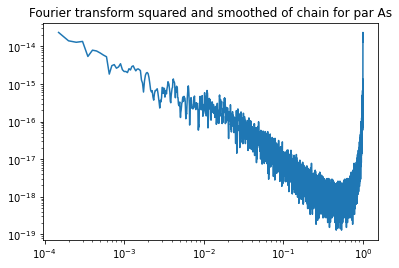

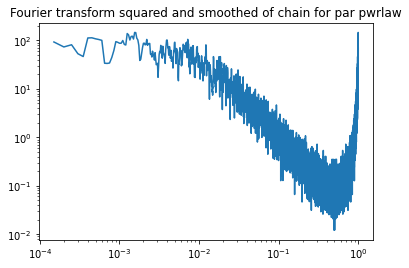

In [12]:
#testing for convergence.
#examine previous plots of parameters versus steps by eye, but also plot fourier transform.

conv = np.fft.fft(chain, axis=0)

labels=['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
xnorm = np.arange(0, chain.shape[0])/chain.shape[0]

#plot fourier transform
# for ii in range(chain.shape[1]):
#     mpl.figure()
#     mpl.plot(xnorm, np.abs(conv[:, ii])**2)
#     mpl.xscale('log')
#     mpl.yscale('log')
#     mpl.title('Fourier transform of chain for par ' + labels[ii])
#     if ii in [0, 1, 2, 5]:
#         mpl.ylim([min(np.abs(conv[:, ii])**2), max(np.abs(conv[:, ii])**2)/1000])
#     else:
#         mpl.ylim([min(np.abs(conv[:, ii])**2), max(np.abs(conv[:, ii])**2)/10])
#     mpl.show()
    
#smooth
conv2_smooth = np.copy(conv)
conv2_smooth = np.abs(conv2_smooth)**2
av = 5
for ii in range(chain.shape[1]):
    box = np.ones(av)/float(av)
    conv2_smooth[:, ii] = np.convolve(conv2_smooth[:, ii], box, mode="same")
    
    mpl.figure()
    #smoothing messes up first few data points
    mpl.plot(xnorm[3:], conv2_smooth[3:, ii])
    mpl.xscale('log')
    mpl.yscale('log')
    mpl.title('Fourier transform squared and smoothed of chain for par ' + labels[ii])
#     if ii in [0, 1, 2, 5]:
#         mpl.ylim([min(conv2_smooth[:, ii]), max(conv2_smooth[:, ii])/10])
#     else:
#         mpl.ylim([min(conv2_smooth[:, ii]), max(conv2_smooth[:, ii])/10])
    mpl.show()

Again we see convergence (flattening on lhs of spectrum) for all except tau and As.

## FINAL COMPARISON

In [13]:
# FINAL COMPARISON:

print('\n FINAL WEIGHTED VALUES: ')
for ii in range(chain.shape[1]):
    print('IMPORTANCE SAMPLING ', par_lab[ii], ' : ', par_mean_weighted[ii], ' error: ', par_errs_weighted[ii])
    print('CHAIN WITH PRIORS   ', par_lab[ii], ' : ', chainmeans[ii], ' error: ', chainsigs[ii])


 FINAL WEIGHTED VALUES: 
IMPORTANCE SAMPLING  h0  :  67.20549859877003  error:  4.3142425535851485
CHAIN WITH PRIORS    h0  :  69.5495585902042  error:  2.112301901194533
IMPORTANCE SAMPLING  wbh^2  :  0.022770984832348285  error:  0.0005952613702927747
CHAIN WITH PRIORS    wbh^2  :  0.022511336039129387  error:  0.00047666973082954005
IMPORTANCE SAMPLING  wch^2  :  0.1242811035965046  error:  0.01029251883779077
CHAIN WITH PRIORS    wch^2  :  0.11347772313574708  error:  0.004449668315003294
IMPORTANCE SAMPLING  tau  :  0.05058028139166173  error:  0.003281835218600055
CHAIN WITH PRIORS    tau  :  0.056822584570994525  error:  0.008307595815891243
IMPORTANCE SAMPLING  As  :  2.129886362959842e-09  error:  5.960531895850692e-11
CHAIN WITH PRIORS    As  :  2.067590014669893e-09  error:  4.5799815462641156e-11
IMPORTANCE SAMPLING  pwrlaw  :  0.9588071678449408  error:  0.01652703423401881
CHAIN WITH PRIORS    pwrlaw  :  0.9702563274885175  error:  0.011679836516182132


The values are within errors for eachother and the errors are max a factor of 2 different, biggest for wch^2.

### Extra added in: sampling with prior vs sampling with edge
Note that these were run with a slow-to-converge cholesky matrix (it remains VERY unconverged at 12000 steps, which you can see visually from graphs of the chain).

##### Comparing the prior method with the gaussian to the method with the edge.
Both had similar values and convergence rates, the edge one had a slightly better error on tau but slightly worse everything else.

The final version of the code was run with the prior rather than the edge because it seemed like more fun.

chain sigmas are  [2.01295807e+00 4.27450789e-04 4.41514850e-03 8.18286104e-03
 4.62069645e-11 1.15367064e-02]
chain means are  [6.94441481e+01 2.24548405e-02 1.13681562e-01 5.36210209e-02
 2.05603039e-09 9.70169532e-01]

 FINAL VALUES: 
final value for par  h0  :  69.44414807373725  error:  2.012958071041089
final value for par  wbh^2  :  0.02245484047219258  error:  0.00042745078903655567
final value for par  wch^2  :  0.11368156241298585  error:  0.004415148499093048
final value for par  tau  :  0.05362102087710051  error:  0.00818286103911695
final value for par  As  :  2.056030393316957e-09  error:  4.6206964496764907e-11
final value for par  pwrlaw  :  0.970169531642734  error:  0.011536706423942163


total count is  172
length of chain is  12000
acceptance rate is  0.014333333333333333
the acceptance rate of the chain is  0.014333333333333333


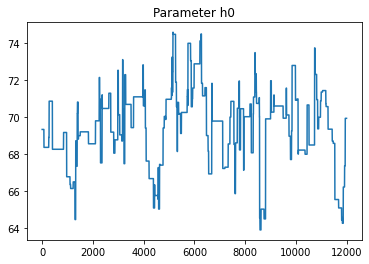

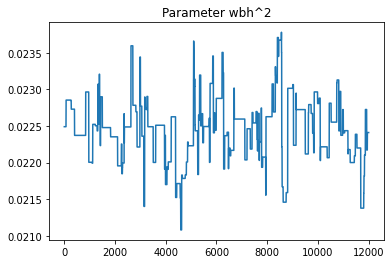

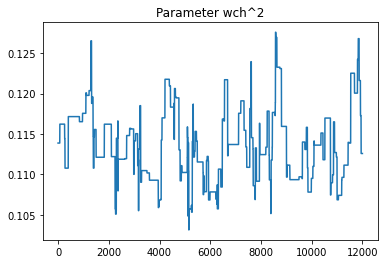

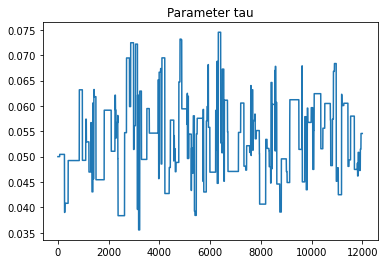

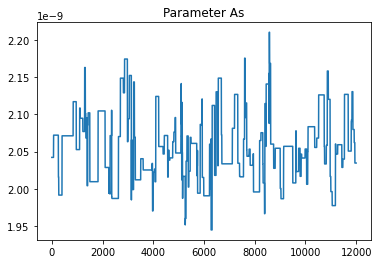

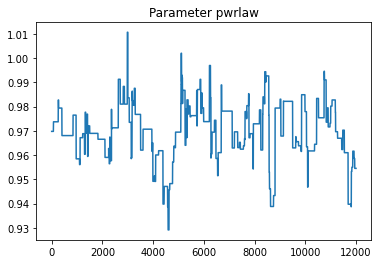

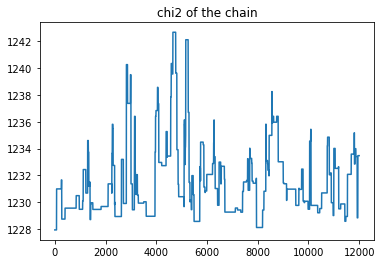

In [14]:
#with priors and bad cholesky

chain = np.loadtxt('chainprior12k.txt')
chi2vec = np.loadtxt('chi2vecprior12k.txt')

chainmeans = np.mean(chain, axis=0)
chainsigs = np.std(chain, axis=0)
print('chain sigmas are ', chainsigs)
print('chain means are ', chainmeans)

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
print('\n FINAL VALUES: ')
for ii in range(chain.shape[1]):
    print('final value for par ', par_lab[ii], ' : ', chainmeans[ii], ' error: ', chainsigs[ii])

print('\n')
print('the acceptance rate of the chain is ', acceptance_rate(chain))

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
for ii in range(len(pars)):
    mpl.figure()
    mpl.plot(chain[:, ii])
    mpl.title('Parameter ' + par_lab[ii])
    mpl.show()
    
mpl.figure()
mpl.plot(chi2vec)
mpl.title('chi2 of the chain')
mpl.show()

chain sigmas are  [2.39723313e+00 4.85246354e-04 5.52482610e-03 4.42510975e-03
 4.20426212e-11 1.20117254e-02]
chain means are  [6.94629087e+01 2.25972739e-02 1.14198375e-01 5.43323921e-02
 2.06077243e-09 9.70081152e-01]

 FINAL VALUES: 
final value for par  h0  :  69.46290865398394  error:  2.397233129182891
final value for par  wbh^2  :  0.0225972739232617  error:  0.00048524635354589086
final value for par  wch^2  :  0.1141983752995054  error:  0.005524826097589851
final value for par  tau  :  0.05433239211586464  error:  0.004425109754614597
final value for par  As  :  2.0607724298675055e-09  error:  4.204262117207347e-11
final value for par  pwrlaw  :  0.9700811516292459  error:  0.0120117254055252


total count is  145
length of chain is  12000
acceptance rate is  0.012083333333333333
the acceptance rate of the chain is  0.012083333333333333


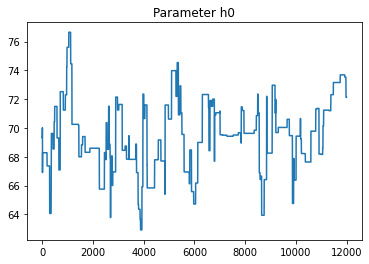

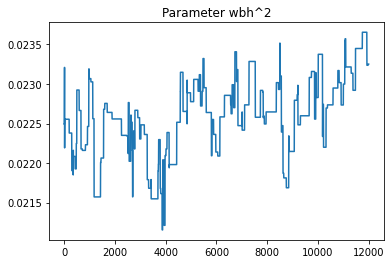

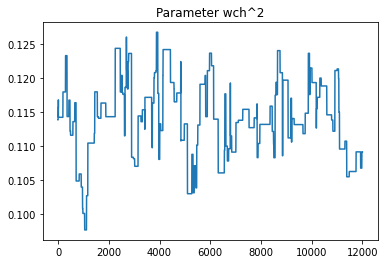

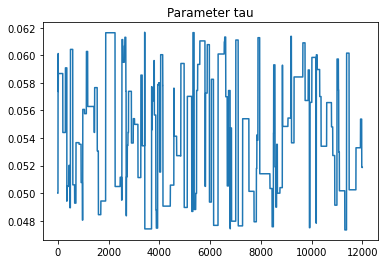

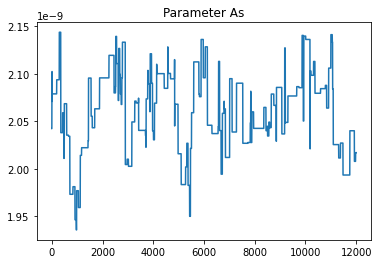

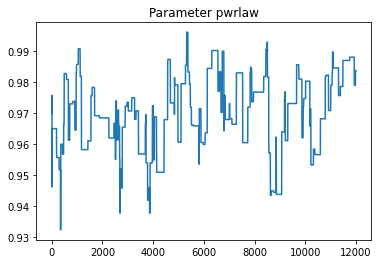

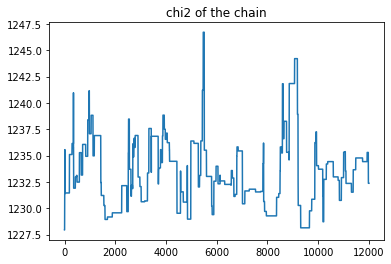

In [15]:
#with edges and bad cholesky

chain = np.loadtxt('chainedge12k.txt')
chi2vec = np.loadtxt('chi2vecedge12k.txt')

chainmeans = np.mean(chain, axis=0)
chainsigs = np.std(chain, axis=0)
print('chain sigmas are ', chainsigs)
print('chain means are ', chainmeans)

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
print('\n FINAL VALUES: ')
for ii in range(chain.shape[1]):
    print('final value for par ', par_lab[ii], ' : ', chainmeans[ii], ' error: ', chainsigs[ii])

print('\n')
print('the acceptance rate of the chain is ', acceptance_rate(chain))

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
for ii in range(len(pars)):
    mpl.figure()
    mpl.plot(chain[:, ii])
    mpl.title('Parameter ' + par_lab[ii])
    mpl.show()
    
mpl.figure()
mpl.plot(chi2vec)
mpl.title('chi2 of the chain')
mpl.show()